## clarte: a flexible tool for common fMRI tasks.

At the center of the toolbox is the fmri_data object, which is loosely based on the fmri_data object from the Canlab toolbox (https://github.com/canlab). It is basically a wrapper for the nipy suite of tools (http://nipy.org/)

- At its core, this object loads, masks, resamples, and reshapes fMRI data. The goal, in its development, was to create a tool that handles the annoying/repetitive aspects of fMRI analyses while being as flexible as possible. 

There are two functions for searchlight analysis: "seachlightSphere" and "searchlightKnn". They both interact with the fmri_data object, and are highly flexible. They support any analysis that can be defined in a function, support parallel computation via joblib, and should be fairly easy to use.

#### Non-Python Dependencies:
- SPM        (requires matlab)
- FSL
- BROCCOLI   (https://github.com/wanderine/BROCCOLI)
- ANTs       (https://stnava.github.io/ANTs/)
- Freesurfer (https://surfer.nmr.mgh.harvard.edu/)


#### Python Dependencies:
- nibabel
- nilearn
- seaborn
- pysurfer (pysurfer.github.io) 
- tqdm (github.com/noamraph/tqdm
- matlab_wrapper

#### Setup:
- add clarte.py to your path
- adjust paths in settings section
- adjust paths in getPeaks

===================================================================================
### A brief demo:
Below, we will load data into the fmri_data object, do some basic preprocessing, and use the searchlightKnn function to run a searchlight analysis.


In [1]:
%matplotlib inline
import glob
import clarte as cl
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.plotting import plot_glass_brain, plot_stat_map
import nilearn.image as nli
import os

/Users/kurtb/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# setup
lssFldr = '/Volumes/TAUREAU/protoGen_4_18_14/scripts/singleTrial_2x2/tMaps/s003'

In [3]:
# find and sort 3d image paths:
imgPaths = np.sort(glob.glob(lssFldr+'/s*.nii'))[:100]
print([os.path.basename(imgPaths[i]) for i in range(5)])
print(len(imgPaths))

['s003_r1_e0001_t.nii', 's003_r1_e0003_t.nii', 's003_r1_e0005_t.nii', 's003_r1_e0007_t.nii', 's003_r1_e0009_t.nii']
100


image dimensions:
(79, 95, 79, 100)
image affine:
[[  -2.    0.    0.   78.]
 [   0.    2.    0. -112.]
 [   0.    0.    2.  -70.]
 [   0.    0.    0.    1.]]


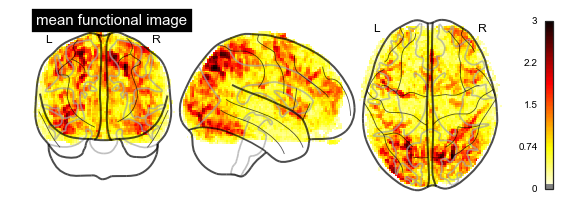

In [4]:
# using nibabel and nilearn, let's take a look at the data:
imgs   = nib.concat_images(imgPaths)
affine = imgs.affine
dim    = imgs.shape

print('image dimensions:')
print(dim)
print('image affine:')
print(affine)

# let's create a mean image and plot it:
im = nib.Nifti1Image(np.mean(imgs.get_data(),axis=3),imgs.affine)
plot_glass_brain(im,title='mean functional image',colorbar=True)

del imgs

So, using nibabel and nilearn, we created a 4d nifti file, with 100 volumes and plotted the mean. Let's do the same with clarte:

In [5]:
dat = cl.fmri_data(imgPaths,'background') 

print(dat)
print(dat.dat.shape)
print('\nfunctional affine matrix:')
print(dat.volInfo['affine']) # the affine of the functional data
print('\nmask affine:')
print(dat.mask['nib'].affine) # that of the calculated mask

<clarte.fmri_data instance at 0x1165a5908>
(100, 189198)

functional affine matrix:
[[  -2.    0.    0.   78.]
 [   0.    2.    0. -112.]
 [   0.    0.    2.  -70.]
 [   0.    0.    0.    1.]]

mask affine:
[[  -2.    0.    0.   78.]
 [   0.    2.    0. -112.]
 [   0.    0.    2.  -70.]
 [   0.    0.    0.    1.]]


With that one-liner, we loaded the functional volumes, calculated an implicit mask, and reshaped the data into a 2-dimensional matrix (100 volumes * 189198 voxels). This is a common format for many machine-learning analyses.

- You might notice that the number of voxels in the dat.dat does not match that of the original image. This is because the dat.dat includes only voxels within the mask.

Let's take a look at the mask we created, and then create mean functional image:


mn vector shape:
(189198,)
im shape:
(79, 95, 79)
mn2 shape:
(189198,)
True


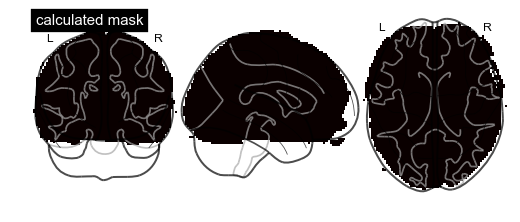

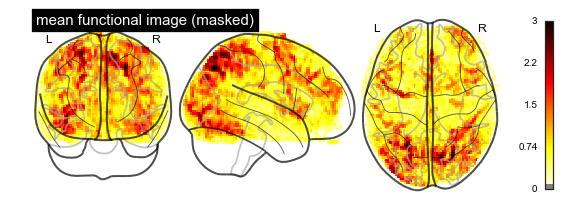

In [6]:
# show the mask:
plot_glass_brain(dat.mask['nib'],title='calculated mask')

# calculate a vector representing the mean for each voxel:
mn = np.mean(dat.dat,axis=0)
print('mn vector shape:')
print(mn.shape)

# unmask the vector to create an image:
im = dat.unmasker(mn)
print('im shape:')
print(im.shape)

# remask the image to create the vector:
mn2 = dat.masker(im)
print('mn2 shape:')
print(mn2.shape)
print(np.allclose(mn,mn2)) 

# plot the mean image
plot_glass_brain(im,title='mean functional image (masked)',colorbar=True)

del mn
del mn2

(The mask doesn't look great. For a real analysis, we might want to try a different strategy.) 

Clarte has other masking options:
- 'full': uses a predefined full-brain MNI mask (the path to which must be specified during setup)
- 'grey' : uses a predefined grey-brain MNI mask (the path to which must be specified during setup)
- 'epi': uses a different algorithm than the 'background' option. It's often not as good as 'background', but is worth trying if 'background' fails.
- a path to a binary-valued image (which will be automatically resampled to the space of the functional volumes).

================================================================
### Preprocessing
The dat object also has functions for doing basic preprocessing.
Let's detrend, standardize, and account for the global signal. (A better way to do this would be with the mean signal from the ventricles.)

In [7]:
dat.cleaner(detrend=True,standardize=True,
                    confounds=dat.dat.mean(axis=1),
                    low_pass=None,high_pass=None)

dat.sessions is empty or contains 1 unique value. Will clean dat.dat by entire columns 


(Note the message above. If dat.sessions is specified, dat.cleaner will automatically clean each session separately.)


Let's take a look at the dat.history:

In [8]:
for i,l in enumerate(dat.history):
    print('%d) '%i+l)

0) imgs masked by "background", & converted to 2d
1) dat.dat cleaned: detrend=True,standardize=True, confounds=True,low_pass=None, high_pass=None


==================================================================
### Searchlight analyses:
#### - There are two seachlight functions
- searchlightKnn: uses a k-nearest neighbors approach, in which each searchlight neighborhood consists of the k-nearest voxels, rather than a fixed sphere radius.

- searchlightSphere: uses a sphere (obviously)

#### Searchlight Example:
- Let's pretend that our dat.dat represents 4 runs, with 25 volumes in each.
- We'll create a dat.sessions vector, preproc the data (again), and then run an analysis using searchlightKnn.

In [9]:
dat.sessions = np.array([[i]*25 for i in np.arange(4)]).ravel()[:dat.dat.shape[0]]
dat.sessions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [10]:
dat.cleaner(detrend=True, standardize=True, 
            confounds=np.mean(dat.dat,axis=1), 
            low_pass=None, high_pass=None)

# Note that, we have now cleaned twice. (only for the sake of the example)
for i,l in enumerate(dat.history):
    print('%d) '%i+l)

dat.dat cleaned by run
0) imgs masked by "background", & converted to 2d
1) dat.dat cleaned: detrend=True,standardize=True, confounds=True,low_pass=None, high_pass=None
2) dat.dat cleaned by run: detrend=True,standardize=True, confounds=True,low_pass=None, high_pass=None


To demo the searchlightKnn function, let's create a (random) binary 'y' vector, which we will decode using a searchlight:

In [11]:
dat.y = np.array([0,1]*50)
np.random.shuffle(dat.y)

print(dat.y.shape)
print(dat.y[:20]) # the first 20 values

(100,)
[0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1]


#### Next, we will specify the analysis we want to run (as a function).

- The function must accept two inputs: X, and y:

    - X will be the functional data from the searchlight (a 2d matrix: samples*voxels)
    
    - y will be dat.y
    
- The function must return a scalar

- Even if the analyis is unsupervised (i.e., does not use the y vector) you must specify dat.y 

    - e.g, dat.y = np.array([])
    
    

Let's make a function that will run a cross-validated decoding analysis:

In [12]:
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.svm import LinearSVC
cv = LeaveOneLabelOut(labels=dat.sessions)
svc = LinearSVC(C=.01)

# the key analysis function:
def pipeline(X,y): 
    ypred = np.zeros_like(y)
    for tr,te in cv:
        ypred[te] = svc.fit(X[tr,:],y[tr]).predict(X[te,:])
    return (ypred==y).mean()

dat.pipeline = pipeline

For speed, let's run the searchlight over a small ROI instead of the full brain. We can do this by specifying a dat.processMask:

/Users/kurtb/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:430: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


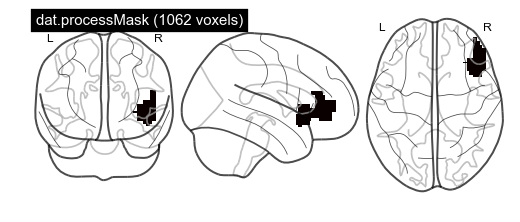

In [13]:
maskPath='/Volumes/Thames/mack/scripts/decod/res/clstrIms/manualRois/wroi/noGamma_attention_domCatAct_tfceTval010_thresh_rInfFrontOrb.nii'
dat.processMask = nli.resample_to_img(maskPath,im,interpolation='nearest')

plot_glass_brain(dat.processMask,title='dat.processMask (%d voxels)'%dat.processMask.get_data().sum())

We could now call searchlightKnn: "im = k.searchlightKnn(dat, knn=50,n_jobs=2)"

However, because it takes time to identify the neighborhoods surrounding each voxel, it can be more efficient to find the neighborhoods first (so that you can save them and re-use them).

- This can be done with getSearchlights. This function outputs a data frame ('dfCoords') and a numpy array ('mKnn'):

    - dfCoords: 
        - (nVoxels*3) pandas dataframe representing matrix coordinates of all voxels 
        - (matrix coordinates can be converted to image coordinates via nilearn.image.resampling.coord_transform)
    
    - mKnn: 
        - (nVoxels*knn) numpy array (where knn = nVoxels per searchlight)
        - used to index dfCoords
    


In [14]:
knn = 50 # number of voxels per searchlight
dfCoords, mKnn = cl.getSearchlights(dat,knn)

print(dfCoords.shape)
print(mKnn.shape)

finding KNN's: 100%|██████████| 1062/1062 [00:00<00:00, 15688.92it/s]

Calculating voxel distances...
(1062, 3)
(1062, 50)


In [15]:
# Pass dfCoords & mKnn to seachlightKnn, and run:
im = cl.searchlightKnn(dat,knn, dfCoords=dfCoords, mKnn=mKnn, n_jobs=1)

running sLight, n_jobs=1: 100%|██████████| 1062/1062 [02:29<00:00,  7.75it/s]


(189198,)
(189198,)


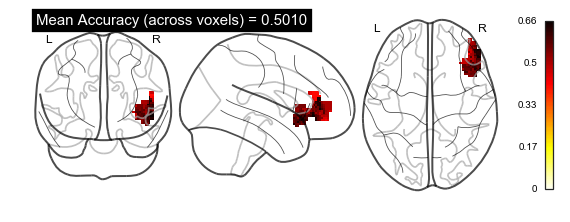

In [16]:
maskIdx = dat.masker(dat.processMask).astype(bool)
vRes = dat.masker(im)
print(maskIdx.shape)
print(vRes.shape)
plot_glass_brain(im,title='Mean Accuracy (across voxels) = %4.4f'%vRes[maskIdx].mean(),colorbar=True)

In [17]:
cl.getPeaks(im)

TypeError: only length-1 arrays can be converted to Python scalars